# This script is used to explore flow events for @212042

In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
import os

# Import local functions
from functions import plot_storm_cq
from functions import CQModel

In [2]:
# Define dir and site
site = '212042'
fig_dir = f'../output/figs/{site}/'
date_postfire = pd.to_datetime('2020-01-01')
date_postyear = pd.to_datetime('2021-06-30')
date_preyear = pd.to_datetime('2016-07-01')
freq = 'Hourly'
font_size = 14
Q_thre = 1

## 1 Data processing and formating

In [3]:
# Process data to format that R package requires for storm event separation.
fn = f'../data/{site}_{freq}.csv'
output_fn = f'../output/{site}_{freq}.csv'
# Read the formated file if it exists.
if os.path.exists(output_fn):
    cq_data = pd.read_csv(output_fn, index_col = 'id')
else: #Generate the formated file if it does not exist.
    cols = ['Rainfall (mm)', 'Discharge (ML/d)', 'Turbidity (NTU)'] # site 212058 does not have rainfall data from the web. 'Rainfall (mm)', 
    cq_data = pd.read_csv(fn, index_col = 'Date and time', skiprows = 3, usecols = [0, 1, 3, 5])
    cq_data.rename(columns={cq_data.columns[ii]: cols[ii] for ii in range(len(cols))}, inplace = True)
    cq_data.index.name = 'Datetime'
    # Process data
    # Drop rows if Turbidity is of value NaN
    cq_data.dropna(axis = 0, how = 'any', inplace = True)
    cq_data.index = pd.to_datetime(cq_data.index, dayfirst = True)
    cq_data.reset_index(inplace=True)
    cq_data['Discharge (cms)'] = round(cq_data['Discharge (ML/d)'] * 1e3 / 86400, 3)
    cq_data.to_csv(f'../output/{site}_{freq}.csv', index_label='id')

## 2. Plots show start of postfire for each catchment.
Timeseries is trimmed for this purpose.

### 2.1 Plot for 212042

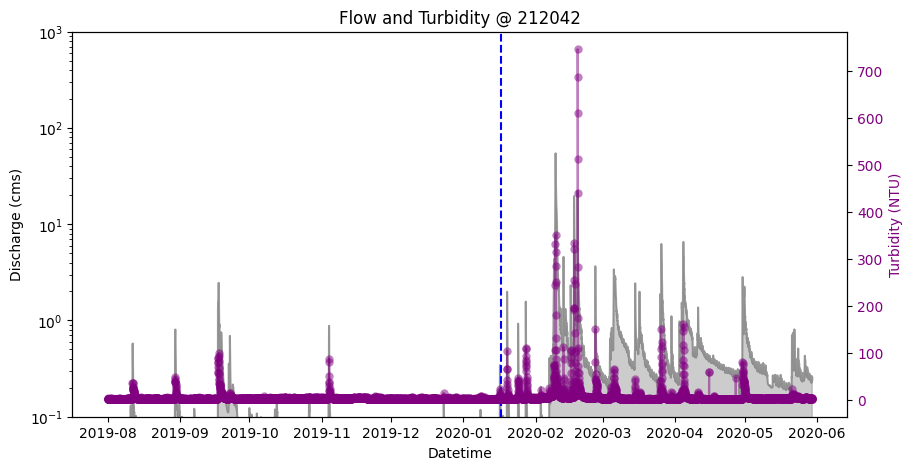

In [9]:
# Set up the figure and axes
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
# convert Datatime column to datetime format
cq_data['Datetime'] = pd.to_datetime(cq_data['Datetime'], format="mixed", dayfirst=True) #  %H:%M
cq_plot = cq_data[(cq_data['Datetime'] < '2020-5-30') & (cq_data['Datetime'] > '2019-8-01')]
# cq_plot = cq_data
cols = cq_plot.columns
# Plot rainfall using Seaborn
plt.title(f'Flow and Turbidity @ {site}')
# Plot discharge using Seaborn
sns.lineplot(x=cols[0], y=cols[4], data=cq_plot, ax=ax1, color='grey', alpha=0.7)
# Fill the area below the line
ax1.fill_between(cq_plot[cols[0]], cq_plot[cols[4]], color='grey',  alpha=0.4)
ax1.set_yscale('log')
ax1.set_ylabel(cols[4], color='black')
ax1.set_ylim(0.1, 1e3)
ax1.tick_params(axis='y', labelcolor='black')
# Create a second y-axis for rainfall
ax2 = ax1.twinx()

# Plot Turbidity using Seaborn
sns.lineplot(x=cols[0], y=cols[3], data=cq_plot, ax=ax2, color='purple', marker='o', \
            markeredgecolor='none', alpha = 0.5)
ax2.set_ylabel(cols[3], color='purple')
ax2.tick_params(axis='y', labelcolor='purple')

# Add a horizontal line at a specific y-value (for example, y = 5)
# ax1.axhline(y=10, color='grey', linestyle='--', label='Threshold Line')
ax1.axvline(x=pd.to_datetime('2020-01-17'), color='blue', linestyle='--', label='Threshold Line')
# Adding a title

# Show the plot
plt.savefig(f'{fig_dir}{site}_{freq}_CQ_whole_timeseries.png', bbox_inches = 'tight', dpi=300, format = 'png')

## 1-0 Plot event duration and peak flow distribution.

In [4]:
# Read the StormEventSummaryData
storm_summary = pd.read_csv('../output/CQ_analysis/212042/' + \
                            '212042_NTU_StormEventSummaryData.csv', index_col = 'id')

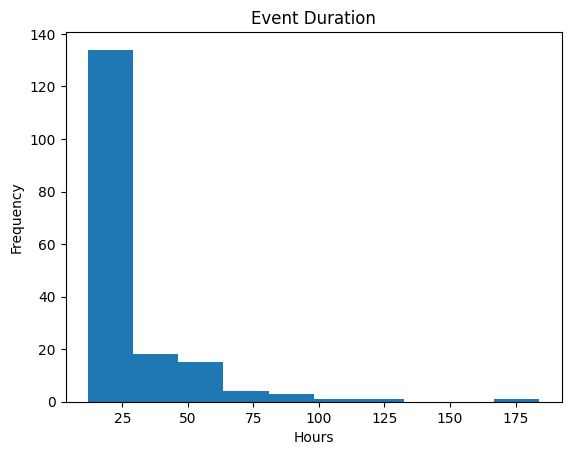

In [5]:
# Hist plot of Event Duration (Hours)
storm_summary.duration_hrs.plot(kind='hist')
plt.xlabel('Hours')
plt.title('Event Duration')
plt.savefig(f'{fig_dir}EventDurationHrs.png', format = 'png', dpi=300)

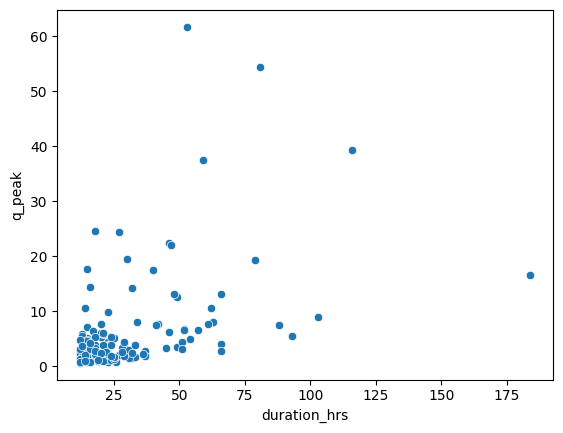

In [6]:
# Scatter plot of Event Duration and Peakflow
sns.scatterplot(data=storm_summary, x = 'duration_hrs', y = 'q_peak')
plt.savefig(f'{fig_dir}EventDurationVsPeakFLow.png', format = 'png', dpi=300)

## 1-1 Explore C-Q for pre and post fire periods


In [7]:
from functions import plot_storm_cq

In [8]:
# Read storm event data
Q_thre = 0.6
storm_data = pd.read_csv('../output/CQ_analysis/212042/' + f'Q_above_{Q_thre}_212042_StormEventRefilterData.csv', index_col = 'id')
cols = storm_data.columns
storm_data['Datetime'] = pd.to_datetime(storm_data['Datetime'])
site = 212042
x_lab = cols[4]
y_lab = cols[3]

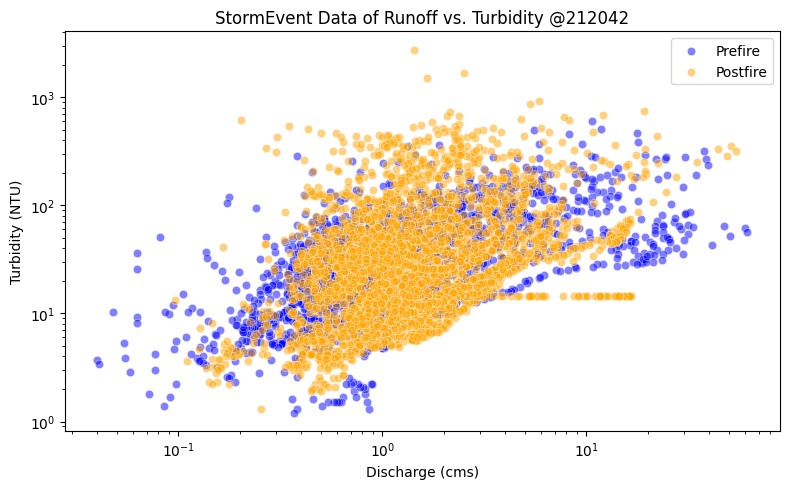

In [9]:
# Scatter plot
plot_storm_cq(storm_data, x_lab, y_lab, freq, site, date_postfire, Q_thre, colors = ['blue', 'orange'], marker='o', \
                  alpha = 0.5, labels = ['Prefire', 'Postfire'])

## Calculate whether coefficients are significantly different

In [10]:
# Regression coefficients of different models
mean_coeff = np.array([[2.52, 2.24, 2.37], [0.09, 0.18, 0.13]])
std_coeff = np.array([[0.15, 0.15, 0.13], [0.09, 0.07, 0.07]])
from scipy.stats import t
t_value = (mean_coeff[1][0] - mean_coeff[1][1]) / (std_coeff[1][0]**2 + std_coeff[1][1]**2)**0.5
# 自由度（近似）
df = storm_data.shape[0]  - 4 # 根据样本大小调整
p_value = 2 * (1 - t.cdf(abs(t_value), df=df))

print(f"T-value: {t_value}, P-value: {p_value}")
if p_value <= 0.05:
    print('There is significant difference in coefficient b for models fitted by pre- and post-fire data')

T-value: -0.7893522173763262, P-value: 0.4299411681540177


In [11]:
# Data filter for 2016-2021
# Read storm event data
Q_thre = 0.6
storm_data = pd.read_csv('../output/CQ_analysis/212042/' + f'Q_above_0.6_212042_StormEventRefilterData.csv', index_col = 'id')
cols = storm_data.columns
storm_data['Datetime'] = pd.to_datetime(storm_data['Datetime'])
site = 212042

In [12]:
storm_data_slice = storm_data[(storm_data['Datetime'] >= date_preyear) & (storm_data['Datetime'] <= date_postyear)]
storm_data_slice.to_csv('../output/CQ_analysis/212042/'+ f'212042_StormEvent_2016_2021.csv', index_label = 'id')